# GPT-4 API: Extract Structured Data from SEC Filings (Material Event Disclosures) and Analyze Stock Returns

Before starting, create a `.env` file in the root directory of the project and add the following environment variables:

```bash
OPENAI_API_KEY=your_openai_api_key
SEC_API_KEY=your_sec_api_key
```

## Structure

**Objective:** Analyze impact of non-reliance on previously issued financial statements disclosures on stock returns.

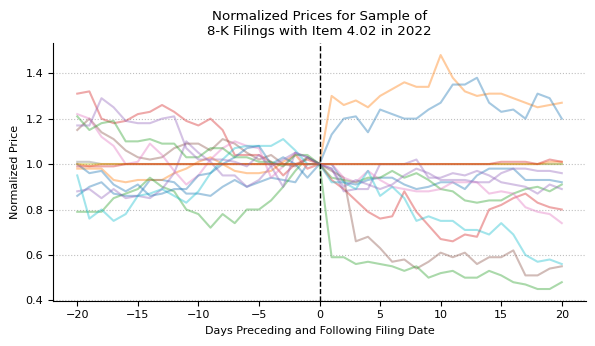

**Steps:**

1. [Learn about SEC Form 8-K filings and different types of disclosures.](./8K-background.ipynb)
1. Find and build a list of URLs of 8-K filings with Item 4.02 (Non-Reliance on Previously Issued Financial Statements).
1. Extract and download the Item 4.02 sections of the filings.
1. Use GPT-4 to extract structured data from the Item 4.02 sections.
1. Calculate 1-to-20 day returns after disclosure for each filing.
1. Descriptive statistics and return distributions for various subsets.
1. [Exercise] Enrich data with fundamental data and calculate returns based on financial metrics.

**Data sources:**
- [SEC-API.io](https://sec-api.io/)
  - [Query API](https://sec-api.io/docs/query-api) to find URLs of all 8-K filings with Item 4.02
  - [Extractor API](https://sec-api.io/docs/sec-filings-item-extraction-api) to extract and download Item 4.02 sections 
- AlgoSeek for historical stock prices
- [Exercise] [WRDS Compustat Daily Updates - Fundamentals Quarterly](https://wrds-www.wharton.upenn.edu/pages/get-data/) for fundamental data


More information about SEC Form 8-K filings and tutorials are available at [SEC-API.io](https://sec-api.io/resources/analyze-8-k-filings-and-material-event-disclosure-activity).

## Step 1: Locate URLs of 8-K filings with Item 4.02

In [1]:
# load OPENAI_API_KEY value from .env file
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
!pip -q install sec-api

In [3]:
import os
from sec_api import QueryApi
import pandas as pd

SEC_API_KEY = os.getenv("SEC_API_KEY")

queryApi = QueryApi(api_key=SEC_API_KEY)

# Define search query to get 8-K filings with item 4.02 filed in 2022.
# In this example, we fetch the first 50 results.
payload = {
    # Search query written in Lucene syntax
    "query": 'formType:"8-K" AND items:"4.02" AND filedAt:[2022-01-01 TO 2022-12-31]',
    # Starting index of the results. Increment by 50 to get the next page of results.
    "from": "0", 
    # Number of results to return per API call
    "size": "50", 
     # Sort by filedAt in descending order
    "sort": [{"filedAt": {"order": "desc"}}],
}

# Format of response is explained at 
# https://sec-api.io/docs/query-api#response-format
response = queryApi.get_filings(payload)

# Convert JSON array to DataFrame
metadata_sample = pd.DataFrame(response["filings"])

columns_of_interest = [
    "formType", # EDGAR form type
    "filedAt", # Date the filing was accepted by the EDGAR system
    "accessionNo", # Unique identifier for the filing
    "ticker", # Stock ticker
    "cik", # Central Index Key: unique identifier for a company
    "companyName", # Name of the company
    "items", # List of items in the filing
    "linkToFilingDetails",  # URL to the filing
]

print(f"Number of filings: {metadata_sample.shape[0]}")
metadata_sample[columns_of_interest].head(5)

Number of filings: 50


,formType,filedAt,accessionNo,ticker,cik,companyName,items,linkToFilingDetails
0,8-K,2022-12-27T16:20:13-05:00,0001213900-22-082892,POLCQ,1810140,Polished.com Inc.,[Item 4.01: Changes in Registrant's Certifying...,https://www.sec.gov/Archives/edgar/data/181014...
1,8-K,2022-12-22T16:30:53-05:00,0001493152-22-036320,GLLI,1888734,GLOBALINK INVESTMENT INC.,[Item 4.02: Non-Reliance on Previously Issued ...,https://www.sec.gov/Archives/edgar/data/188873...
2,8-K,2022-12-21T17:25:38-05:00,0001213900-22-081850,CLRC,1903392,ClimateRock,[Item 4.02: Non-Reliance on Previously Issued ...,https://www.sec.gov/Archives/edgar/data/190339...
3,8-K,2022-12-16T16:17:36-05:00,0001185185-22-001426,FEIM,39020,FREQUENCY ELECTRONICS INC,[Item 2.02: Results of Operations and Financia...,https://www.sec.gov/Archives/edgar/data/39020/...
4,8-K,2022-12-16T16:05:27-05:00,0001493152-22-035733,VTRO,793171,"Vitro Biopharma, Inc.",[Item 4.02: Non-Reliance on Previously Issued ...,https://www.sec.gov/Archives/edgar/data/793171...


In [4]:
# Get first 50 filings of each month in 2022 (for demonstration purposes only)
# In practice, you would want to get all filings for the year (or a longer period of time)
def get_filings_metadata(year=2022):
    metadata_list = []

    for month in range(1, 13):
        # Iterate over "from" in 50 increments to get all filings for the year
        # for i in range(0, 10000, 50): # Uncomment to get all filings for the year
        for i in range(
            0, 50, 50
        ):  # For demonstration purposes, only get first 50 filings of each month
            start_date = f"{year}-{month:02d}-01"
            end_date = f"{year}-{month:02d}-31"
            query = f'formType:"8-K" AND items:"4.02" AND filedAt:[{start_date} TO {end_date}]'
            payload = {
                "query": query,
                "from": i,
                "size": "50",
                "sort": [{"filedAt": {"order": "desc"}}],
            }
            response = queryApi.get_filings(payload)
            if len(response["filings"]) == 0:
                break
            metadata_list.append(response["filings"])

        print(f"✅ Month {month:02d} completed")

    # Flatten the list of lists: [[1, 2], [3, 4]] -> [1, 2, 3, 4]
    metadata_list = [item for sublist in metadata_list for item in sublist]
    # Convert JSON array to DataFrame
    metadata_df = pd.DataFrame(metadata_list)
    # Drop duplicates
    metadata_df = metadata_df.drop_duplicates(subset=["accessionNo"])

    print(f"✅ Done. Total filings: {len(metadata_list)}")

    return metadata_df[
        [
            "formType",
            "filedAt",
            "accessionNo",
            "ticker",
            "cik",
            "companyName",
            "items",
            "linkToFilingDetails",
        ]
    ]

In [5]:
metadata_2022 = get_filings_metadata(2022)

✅ Month 01 completed
✅ Month 02 completed
✅ Month 03 completed
✅ Month 04 completed
✅ Month 05 completed
✅ Month 06 completed
✅ Month 07 completed
✅ Month 08 completed
✅ Month 09 completed
✅ Month 10 completed
✅ Month 11 completed
✅ Month 12 completed
✅ Done. Total filings: 305


In [6]:
metadata_2022.head(5)

,formType,filedAt,accessionNo,ticker,cik,companyName,items,linkToFilingDetails
0,8-K,2022-01-31T21:35:24-05:00,0001829126-22-002268,,1740742,"TransparentBusiness, Inc.",[Item 4.01: Changes in Registrant's Certifying...,https://www.sec.gov/Archives/edgar/data/174074...
1,8-K,2022-01-31T08:50:59-05:00,0001104659-22-009285,OEPW,1824677,One Equity Partners Open Water I Corp.,[Item 4.02: Non-Reliance on Previously Issued ...,https://www.sec.gov/Archives/edgar/data/182467...
2,8-K,2022-01-31T07:03:59-05:00,0001564590-22-003120,BIOCQ,1044378,BIOCEPT INC,[Item 4.02: Non-Reliance on Previously Issued ...,https://www.sec.gov/Archives/edgar/data/104437...
3,8-K,2022-01-28T17:40:28-05:00,0001213900-22-004297,SCAQ,1821812,Stratim Cloud Acquisition Corp.,[Item 4.02: Non-Reliance on Previously Issued ...,https://www.sec.gov/Archives/edgar/data/182181...
4,8-K,2022-01-28T17:02:06-05:00,0001193125-22-021724,DTRT,1865537,DTRT Health Acquisition Corp.,[Item 4.02: Non-Reliance on Previously Issued ...,https://www.sec.gov/Archives/edgar/data/186553...


In [7]:
# Save the DataFrame to a CSV file ./data/edgar/8K-filing-metadata.csv
metadata_2022.to_csv("./data/edgar/8K-filing-metadata.csv", index=False)

## Step 2: Download Item 4.02 sections

We use the [Extractor API](https://sec-api.io/docs/sec-filings-item-extraction-api) to extract and download the Item 4.02 sections of the filings and save them as text files. `pandarallel` is used to parallelize downloading of Item 4.02 sections and speed up the process.

In [8]:
from sec_api import ExtractorApi
import time

extractorApi = ExtractorApi(SEC_API_KEY)


def extract_section_4_02_and_save_to_file(df_row, retry_count=0):
    cik = df_row["cik"]
    accessionNo = df_row["accessionNo"]
    filingUrl = df_row["linkToFilingDetails"]
    itemId = "4-2"

    try:
        # Check if output directory exists, if not create it
        output_dir = f"./data/edgar/8K-item-4.02/{cik}"
        os.makedirs(output_dir, exist_ok=True)
        # Save extracted text to a file ./data/edgar/{cik}/{accessionNo}-item-{itemId}.txt
        file_name = f"{accessionNo}-item-{itemId}.txt"
        file_path = os.path.join(output_dir, file_name)
        # Skip if the file already exists
        if os.path.exists(file_path):
            return
        # Extract the text of the section with itemId and save it to a file
        section_content = extractorApi.get_section(filingUrl, itemId, "text")
        with open(file_path, "w") as f:
            f.write(section_content)

    except Exception as e:
        # If e contains 429, retry the request after waiting for
        # 300 milliseconds to the power of retry_count
        if "429" in str(e) and retry_count < 3:
            print(f"Retrying for CIK {cik} at {filingUrl}")
            time.sleep(0.3 ** (retry_count + 1))
            return extract_section_4_02_and_save_to_file(df_row, retry_count + 1)
        else:
            print(f"Failed to extract item {itemId} for CIK {cik} at {filingUrl}")
            print(e)

In [9]:
# Test the function with a single row
single = metadata_2022.iloc[0]
extract_section_4_02_and_save_to_file(single)

In [10]:
!pip -q install pandarallel ipywidgets

In [11]:
from pandarallel import pandarallel

number_of_parallel_downloads = 10

pandarallel.initialize(
    progress_bar=True, nb_workers=number_of_parallel_downloads, verbose=1
)

metadata_2022.parallel_apply(extract_section_4_02_and_save_to_file, axis=1)

print("✅ All sections extracted and saved to files")

✅ All sections extracted and saved to files


## Step 3: Use GPT-4 API to extract structured data from Item 4.02 sections

We use the [Chat Completion API](https://platform.openai.com/docs/guides/text-generation/chat-completions-api) and GPT-4 to extract structured data from the Item 4.02 sections.

In [12]:
from IPython.display import display, HTML

# Load an extracted section from a sample filing
sample_filing = metadata_2022.iloc[0]
cik = sample_filing["cik"]
accessionNo = sample_filing["accessionNo"]
filingUrl = sample_filing["linkToFilingDetails"]
file_name = f"{accessionNo}-item-4-2.txt"
file_path = f"./data/edgar/8K-item-4.02/{cik}/{file_name}"

with open(file_path, "r") as f:
    sample_section = f.read()

print(f"📄 Sample section from {filingUrl}")
display(HTML(sample_section))

📄 Sample section from https://www.sec.gov/Archives/edgar/data/1740742/000182912622002268/transparentbusiness_8k.htm


In [13]:
from openai import OpenAI

openai_client = OpenAI()

prompt = f"""Task: Given the following 8-K filing section 4.02, extract the key components of the disclosure, the identified issue (or issues), affected reporting periods, whether a restatement is neccesary or not, the reasons for a restatement, the impact of the error, whether the impact is material or not, the company's auditor, and the event classiciation. Return the extracted structured data as a JSON object. Only respond with the JSON object, and do not respond with anything else.

Structure of JSON object:
'''
{{
  "keyComponents": "...", // string: key components of the disclosure
  "identifiedIssue": ["..."], // array of strings: identified issue (or issues)
  "affectedReportingPeriods": ["..."], // array of strings: affected reporting periods in format "Q1 2023", "Q2 2023", etc. or "FY 2023"
  "restatementIsNecessary": true|false, // boolean: whether a restatement is necessary or not
  "reasonsForRestatement": ["..."], // array of strings: reasons for a restatement
  "impactOfError": "...", // string: impact of the error
  "impactIsMaterial": true|false, // boolean: whether the impact is material or not
  "auditors": ["..."], // array of string: company's auditor or auditors. If no auditor is mentioned, return an empty array. If multiple auditors are mentioned, return an array with all auditors.
  "eventClassification": "..." // string: event classification, such as "Financial Restatement Due to Revenue Recognition Errors"
}}
'''

Input text:
'''
{sample_section}
'''

Response:
"""

response = openai_client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[{"role": "user", "content": prompt}],
)

In [14]:
response_string = response.choices[0].message.content
print(response_string)

{
  "keyComponents": "Non-reliance on previously issued financial statements due to errors in deferred tax liabilities and income tax disclosures, needing restatement.",
  "identifiedIssue": [
    "Errors in accounting for deferred tax liabilities.",
    "Incorrect netting of deferred tax liabilities against deferred tax assets due to non-consolidated tax filings."
  ],
  "affectedReportingPeriods": [
    "FY 2020"
  ],
  "restatementIsNecessary": true,
  "reasonsForRestatement": [
    "Material error in deferred tax liability accounting.",
    "Understated deferred tax liabilities and Goodwill."
  ],
  "impactOfError": "Understatement of deferred tax liabilities and Goodwill by $969,940.",
  "impactIsMaterial": true,
  "auditors": [
    "Former Auditor",
    "Paris Kreit & Chiu"
  ],
  "eventClassification": "Financial Restatement Due to Errors in Tax Accounting"
}


In [15]:
import json

# Remove starting "```json" and ending "```" values from GPTs response
response_string = response_string.replace("```json\n", "").replace("```", "").replace("\n", "")
# Convert to JSON object
extracted_data_json = json.loads(response_string)
extracted_data_json

{'keyComponents': 'Non-reliance on previously issued financial statements due to errors in deferred tax liabilities and income tax disclosures, needing restatement.',
 'identifiedIssue': ['Errors in accounting for deferred tax liabilities.',
  'Incorrect netting of deferred tax liabilities against deferred tax assets due to non-consolidated tax filings.'],
 'affectedReportingPeriods': ['FY 2020'],
 'restatementIsNecessary': True,
 'reasonsForRestatement': ['Material error in deferred tax liability accounting.',
  'Understated deferred tax liabilities and Goodwill.'],
 'impactOfError': 'Understatement of deferred tax liabilities and Goodwill by $969,940.',
 'impactIsMaterial': True,
 'auditors': ['Former Auditor', 'Paris Kreit & Chiu'],
 'eventClassification': 'Financial Restatement Due to Errors in Tax Accounting'}

In [16]:
print("✅ Extracted data from the 8-K filing section 4.02")
print("Event classification:", extracted_data_json["eventClassification"])
print("Impact of the error:", extracted_data_json["impactOfError"])

✅ Extracted data from the 8-K filing section 4.02
Event classification: Financial Restatement Due to Errors in Tax Accounting
Impact of the error: Understatement of deferred tax liabilities and Goodwill by $969,940.


In [17]:
# Load the extracted structured data into a DataFrame
structured_data_sample = pd.json_normalize(extracted_data_json)
structured_data_sample

,keyComponents,identifiedIssue,affectedReportingPeriods,restatementIsNecessary,reasonsForRestatement,impactOfError,impactIsMaterial,auditors,eventClassification
0,Non-reliance on previously issued financial st...,[Errors in accounting for deferred tax liabili...,[FY 2020],True,[Material error in deferred tax liability acco...,Understatement of deferred tax liabilities and...,True,"[Former Auditor, Paris Kreit & Chiu]",Financial Restatement Due to Errors in Tax Acc...


In [18]:
# To speed up things, I prepared a CSV file with the extracted structured data
# for all 8-K filings in 2022 with Item 4.02. Let's load it into a DataFrame.
structured_data_2022 = pd.read_csv(
    "./data/edgar/8K-4.02-structured-data-and-metadata-2022.csv",
    parse_dates=["filedAt"],
    # Convert the following columns to lists
    converters={
        "identifiedIssue": eval,
        "affectedReportingPeriods": eval,
        "reasonsForRestatement": eval,
        "auditors": eval,
    },
)
print(f"Number of filings: {structured_data_2022.shape[0]}")
structured_data_2022.head()

Number of filings: 284


,keyComponents,identifiedIssue,affectedReportingPeriods,restatementIsNecessary,reasonsForRestatement,impactOfError,impactIsMaterial,auditors,eventClassification,cik,accessionNo,ticker,filedAt
0,Identification of errors in financial statemen...,[Misclassification of certain expenses and rec...,"[Q1 2022, FY 2021]",True,[To correct classification of certain expenses...,Material weakness in design and operation of e...,True,[Ernst & Young LLP],Financial Restatement Due to Misclassification...,1005286,0001005286-22-000049,LFCR,2022-09-13 21:45:06-04:00
1,"The Board of Intellicheck, Inc. has determined...",[Misclassification of certain option awards as...,"[Q3 2020, Q1 2021, Q2 2021, Q3 2021, FY 2020, ...",True,"[Change in classification of option awards, Ad...",The errors are expected to increase accrued li...,True,[Independent Registered Public Accounting Firm],Financial Restatement Due to Misclassification...,1040896,0001493152-22-014655,IDN,2022-05-20 17:26:31-04:00
2,Non-Reliance on Previously Issued Financial St...,[Failure to accrue for certain expenses incurred],[Q3 2021],True,[Failure to accrue for expenses estimated betw...,Underreported expenses by approximately $1.0 t...,True,[Mayer Hoffman McCann P.C.],Financial Restatement Due to Expense Recogniti...,1044378,0001564590-22-003120,BIOCQ,2022-01-31 07:03:59-05:00
3,Identification of an accounting error in previ...,[Error in the application of Accounting Standa...,"[Q1 2022, Q2 2022]",True,[To correct misstatements in financial stateme...,Overstatement of both fleet new vehicle revenu...,True,[KPMG LLP],Financial Restatement Due to Revenue Recogniti...,1043509,0001043509-22-000016,SAH,2022-10-28 17:00:49-04:00
4,Non-Reliance on Previously Issued Financial St...,[Financial records of Human Brands were defici...,[Q2 2021],True,[Deficiencies in the financial records of Huma...,Non-compliance with Regulation S-X requirement...,True,[B.F Borgers C.P.A.],Financial Restatement Due to Non-Compliance wi...,1058330,0001903596-22-000275,ROAG,2022-05-10 16:53:49-04:00


### Auditors involved in material financial restatements

In [19]:
# Quick look at auditors involved in material restatements
auditors = (
    structured_data_2022[
        structured_data_2022["restatementIsNecessary"]
        & structured_data_2022["impactIsMaterial"]
    ]["auditors"]
    .explode()
    .fillna("NaN")
)

# Remove "Independent registered public accounting firm", "Not specified" and others from list
auditors = auditors[
    ~auditors.isin(
        [
            "Independent registered public accounting firm",
            "Not specified",
            "Not explicitly mentioned",
            "Independent accountant",
            "NaN",
        ]
    )
    # Or if auditor name includes phrase "independent registered public"
    & ~auditors.str.contains("independent registered public", case=False)
    & ~auditors.str.contains("Not explicitly mentioned", case=False)
].reset_index(drop=True)

# Standardize names of auditors to cover slight variations. 
# In practice, you may need to add more complex rules to cover all variations.
# Example: "WithumSmith+Brown, PC" vs "WithumSmith+Brown, P.C."
auditors = auditors.str.replace(r".", "")

# Count the number of times each auditor appears
auditors_count = auditors.value_counts().to_frame().reset_index()
auditors_count["pct"] = auditors_count["count"] / auditors_count["count"].sum() * 100
auditors_count["pct"] = auditors_count["pct"].round(1)

print("🔍 Top 10 auditors involved in material restatements in 2022:")
auditors_count.head(10)

🔍 Top 10 auditors involved in material restatements in 2022:


,auditors,count,pct
0,"WithumSmith+Brown, PC",46,19.9
1,Marcum LLP,35,15.2
2,"BDO USA, LLP",18,7.8
3,Ernst & Young LLP,13,5.6
4,PricewaterhouseCoopers LLP,8,3.5
5,Friedman LLP,6,2.6
6,KPMG LLP,6,2.6
7,RSM US LLP,5,2.2
8,UHY LLP,5,2.2
9,Moss Adams LLP,3,1.3


## Step 4: Calculate 1-20-day pre/post disclosure returns (event study)

- Event studies are used to analyze the impact of an event on stock prices.
- Events can impact entire markets (global, US, etc.), industries (e.g. tech), or individual companies.
- We are interested in the impact of non-reliance on previously issued financial statements disclosures on stock returns of individual companies. 
- Calculate daily returns for all 20 days prior to a disclosure date and 20 days after the disclosure date for each filing.
- Calculate descriptive statistics for each day, with a specific focus on the median and mean 20 days before and 20 days after the disclosure date.

Data source:
- AlgoSeek for historically adjusted stock prices. NOTE: Do not use unadjusted prices, as they do not account for dividends, splits, etc.

NOTE: In practice, you would
- Use a larger dataset and more filings, such as all filings with Item 4.02 in the last 10 years. Otherwise, the sample size is too small to draw meaningful, statistically significant conclusions. 
- Look at excess returns (=returns minus market return) to isolate the impact of the general market movement from the impact of the event.
- Measure the impact across different factors, such as Alpha, Beta, Sharpe Ratio, maximum drawdown, volatility, etc.

In [20]:
stock_prices_2022_8K = pd.read_csv(
    "./data/historical-prices/daily-price-vol-8K-4.02-2022.csv", parse_dates=["Date"]
)

# Add missing dates (e.g. weekends, holidays) for each ticker and forward fill the missing values
stock_prices_2022_8K = (
    stock_prices_2022_8K.groupby("Ticker")
    .apply(lambda x: x.set_index("Date").asfreq("D", method="ffill"))
    .drop(columns=["Ticker"])
    .reset_index()
)

stock_prices_2022_8K.head(10)

/var/folders/q3/bt7922t52p78qdm75h_8m5yh0000gn/T/ipykernel_71307/3289851412.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.set_index("Date").asfreq("D", method="ffill"))


,Ticker,Date,Open,High,Low,Close,Volume,OpenAdjusted,HighAdjusted,LowAdjusted,CloseAdjusted,VolumeAdjusted
0,AACI,2022-01-03,9.8150,9.9100,9.8100,9.884,112300.0,9.8150,9.9100,9.8100,9.884,112300.0
1,AACI,2022-01-04,9.9000,9.9200,9.8600,9.910,1799.0,9.9000,9.9200,9.8600,9.910,1799.0
2,AACI,2022-01-05,9.8824,9.8854,9.8000,9.800,7.0,9.8824,9.8854,9.8000,9.800,7.0
3,AACI,2022-01-06,9.8200,9.8400,9.8000,9.800,447937.0,9.8200,9.8400,9.8000,9.800,447937.0
4,AACI,2022-01-07,9.8900,9.9140,9.8000,9.870,970.0,9.8900,9.9140,9.8000,9.870,970.0
5,AACI,2022-01-08,9.8900,9.9140,9.8000,9.870,970.0,9.8900,9.9140,9.8000,9.870,970.0
6,AACI,2022-01-09,9.8900,9.9140,9.8000,9.870,970.0,9.8900,9.9140,9.8000,9.870,970.0
7,AACI,2022-01-10,9.8400,9.8900,9.8400,9.865,8345.0,9.8400,9.8900,9.8400,9.865,8345.0
8,AACI,2022-01-11,9.8699,9.8700,9.8500,9.870,768.0,9.8699,9.8700,9.8500,9.870,768.0
9,AACI,2022-01-12,9.8600,9.8600,9.8518,9.860,31.0,9.8600,9.8600,9.8518,9.860,31.0


In [21]:
# Create a dict with "TICKER-DATE" as key and "CloseAdjusted" as value
stock_prices_2022_8K["Ticker-Date"] = stock_prices_2022_8K["Ticker"] + "-" + stock_prices_2022_8K["Date"].dt.strftime("%Y-%m-%d")
stock_prices_2022_8K_dict = stock_prices_2022_8K.set_index("Ticker-Date")["CloseAdjusted"].to_dict()

print(f"Tickers loaded: {len(stock_prices_2022_8K['Ticker'].unique())}")
# Show first 10 items in the dictionary
dict(list(stock_prices_2022_8K_dict.items())[:10])

Tickers loaded: 122


{'AACI-2022-01-03': 9.884,
 'AACI-2022-01-04': 9.91,
 'AACI-2022-01-05': 9.8,
 'AACI-2022-01-06': 9.8,
 'AACI-2022-01-07': 9.87,
 'AACI-2022-01-08': 9.87,
 'AACI-2022-01-09': 9.87,
 'AACI-2022-01-10': 9.865,
 'AACI-2022-01-11': 9.87,
 'AACI-2022-01-12': 9.86}

In [22]:
# For each row (filing) in structured_data_2022, get the adjusted closing price for the ticker on the filing date,
# the prices for the 20 days preceding the "filedAt" date, 20 days following the date, and calculate the percentage change in price
# between the filing date and the past/future date(s), and add 1dReturn, 2dReturn, 3dReturn, 5dReturn, 10dReturn, 20dReturn columns
# to structured_data_2022


# Calculate X-day returns
def get_price_changes(ticker, date):
    price_changes = {}
    day0AdjClosePrice = stock_prices_2022_8K_dict.get(
        f"{ticker}-{date.strftime('%Y-%m-%d')}"
    )

    if day0AdjClosePrice is None:
        return None

    # Iterate over days from -20 to +20, one day at a time
    for days in range(-20, 21):
        # Calculate the Timedelta on business days only (excluding weekends)
        date_x = date + pd.offsets.BusinessDay(days)
        date_x_str = date_x.strftime("%Y-%m-%d")
        date_x_key = f"{ticker}-{date_x_str}"
        if date_x_key in stock_prices_2022_8K_dict:
            dayXAdjClosePrice = stock_prices_2022_8K_dict[date_x_key]
            if days < 0:
                price_changes[f"-{abs(days)}dReturn"] = round(
                    (day0AdjClosePrice / dayXAdjClosePrice - 1) * 100, 2
                )
            elif days >= 0:
                price_changes[f"{days}dReturn"] = round(
                    (dayXAdjClosePrice / day0AdjClosePrice - 1) * 100, 2
                )
        else:
            price_changes[f"{days}dReturn"] = None

    return price_changes


data_2022_w_prices = structured_data_2022.copy(deep=True)

data_2022_w_prices["priceChanges"] = data_2022_w_prices.apply(
    lambda x: get_price_changes(x["ticker"], x["filedAt"]), axis=1
)

# Explode priceChanges dicts to separate columns
price_changes_df = pd.json_normalize(data_2022_w_prices["priceChanges"])

# Check if column "1dReturn" exists in structured_data_2022_prices from previous runs
# to avoid adding duplicate columns when re-running the cell
if "1dReturn" in data_2022_w_prices.columns:
    # Drop all columns with "dReturn" suffix
    data_2022_w_prices.drop(
        columns=[col for col in data_2022_w_prices.columns if "dReturn" in col],
        inplace=True,
    )

# Concatenate structured_data_2022_prices and price_changes_df
data_2022_w_prices = (
    pd.concat([data_2022_w_prices, price_changes_df], axis=1)
    .dropna(subset=["1dReturn"])
    .reset_index(drop=True)
)

data_2022_w_prices.drop(columns=["priceChanges"], inplace=True)

print(f"✅ Calculated X-day (-20 to 20) returns for {len(data_2022_w_prices)} filings")
data_2022_w_prices.head()

✅ Calculated X-day (-20 to 20) returns for 127 filings


,keyComponents,identifiedIssue,affectedReportingPeriods,restatementIsNecessary,reasonsForRestatement,impactOfError,impactIsMaterial,auditors,eventClassification,cik,...,11dReturn,12dReturn,13dReturn,14dReturn,15dReturn,16dReturn,17dReturn,18dReturn,19dReturn,20dReturn
0,Identification of an accounting error in previ...,[Error in the application of Accounting Standa...,"[Q1 2022, Q2 2022]",True,[To correct misstatements in financial stateme...,Overstatement of both fleet new vehicle revenu...,True,[KPMG LLP],Financial Restatement Due to Revenue Recogniti...,1043509,...,7.46,9.13,7.35,8.49,9.00,6.32,7.12,8.28,8.28,7.33
1,Non-Reliance on Previously Issued Financial St...,[Improper revenue recognition presentation as ...,"[FY 2021, Q3 2022]",True,[SEC's objection to revenue presentation on a ...,Change in presentation of service revenue from...,False,"[Baker Tilly US, LLP]",Financial Restatement Due to Revenue Recogniti...,1013706,...,-2.70,-4.31,-4.31,-4.31,-3.77,-7.55,-4.04,-7.55,NaN,NaN
2,Accounting irregularities in the Pipeline Engi...,[Accounting irregularities in the financial st...,"[FY 2018, FY 2019, FY 2020, Q1 2020, Q2 2020, ...",True,[Certain misstatements contained in the consol...,Certain misstatements in the consolidated fina...,True,"[Ernst & Young LLP, PricewaterhouseCoopers LLP]",Financial Restatement Due to Revenue Recogniti...,1091883,...,19.49,14.85,13.28,14.09,11.87,7.62,5.28,4.43,2.55,-0.17
3,Non-Reliance on Previously Issued Financial St...,[Errors in the timing of recognition of the Co...,"[FY 2021, Q1 2021, Q2 2021, Q3 2021, Q4 2021, ...",True,[Discrepancies detected between estimated accr...,"Understatement of Reported Revenues, Operating...",True,"[Moss Adams LLP, BDO USA, LLP]",Financial Restatement Due to Revenue Recogniti...,1171155,...,-3.14,-4.05,-5.29,-2.98,-1.32,0.33,-0.83,0.00,0.33,3.55
4,Non-Reliance on Previously Issued Financial St...,[Error in accounting for net unrealized losses...,"[Q1 2022, Q2 2022]",True,[Incorrect classification of net unrealized lo...,Net unrealized losses were incorrectly recorde...,True,[Ernst & Young LLP],Financial Restatement Due to Revenue Recogniti...,1172222,...,-7.55,-10.76,-4.81,-2.26,-2.06,-1.60,-6.90,-7.39,-7.32,-8.21


## Step 5: Analyze and visualize data

In [23]:
# For xdReturn columns, calculate descriptive statistics
price_return_columns = [
    "-20dReturn",
    "-10dReturn",
    "-5dReturn",
    "-3dReturn",
    "-1dReturn",
    "1dReturn",
    "3dReturn",
    "5dReturn",
    "10dReturn",
    "20dReturn",
]

price_return_stats = data_2022_w_prices[price_return_columns].describe().T.round(2)

print("📈 Price return statistics following non-reliance disclosures in 2022:")
price_return_stats

📈 Price return statistics following non-reliance disclosures in 2022:


,count,mean,std,min,25%,50%,75%,max
-20dReturn,105.0,-0.53,10.00,-38.19,-0.82,0.10,0.51,50.99
-10dReturn,115.0,-0.74,7.80,-43.81,-0.52,0.10,0.32,28.72
-5dReturn,125.0,-0.18,6.79,-29.34,-0.21,0.00,0.21,37.74
-3dReturn,125.0,-0.22,4.74,-19.53,-0.21,0.00,0.20,24.94
-1dReturn,127.0,-0.06,4.46,-15.21,-0.18,0.00,0.10,42.67
1dReturn,127.0,0.02,6.82,-40.51,-0.10,0.00,0.10,42.38
3dReturn,127.0,-1.03,9.53,-47.11,-0.26,0.00,0.20,43.33
5dReturn,127.0,-1.66,10.45,-49.47,-0.26,0.00,0.21,32.38
10dReturn,125.0,-2.11,12.33,-51.96,-0.61,0.05,0.31,47.67
20dReturn,122.0,-4.02,14.69,-73.24,-0.58,0.20,0.41,28.10


- Comparing the median (50%) returns of E-X day returns, we don't see a meaningful difference. 
- However, looking at the mean returns, we find a negative impact of non-reliance disclosures on stock returns 20 days after the disclosure date.
- For example, E-20 shows a positive median return of 0.1%, with a negative mean return of -0.53%, while E+20 shows a median return of 0.2% and a negative mean return of -4.02%.
- The difference between the E-20 and E+20 median returns is not meaningful, but the difference in mean +/-20 returns show a negative impact of -3.49%.
- Whether you use median or mean returns depends on the context and the distribution of returns. Median is more robust to outliers, while mean is more sensitive to extreme values.

In [24]:
!pip -q install matplotlib

In [25]:
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use("default")

params = {
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "text.usetex": False,
    "font.family": "sans-serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.color": "grey",
    "axes.grid": True,
    "axes.grid.axis": "y",
    "grid.alpha": 0.5,
    "grid.linestyle": ":",
}

plt.rcParams.update(params)

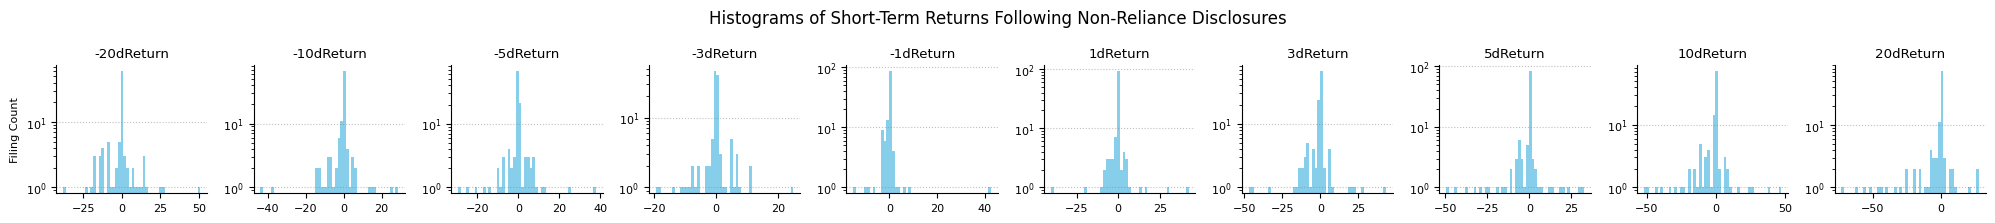

In [26]:
def plot_histograms(returns):
    width = 2 * len(returns.columns)
    plots = len(returns.columns)
    fig, axes = plt.subplots(1, plots, figsize=(width, 2.2))

    for i, ax in enumerate(axes.flatten()):
        if i == 0:
            ax.set_ylabel("Filing Count")
        column = returns.columns[i]
        data_to_plot = returns[column].dropna()
        ax.hist(data_to_plot, bins=50, color="skyblue")
        ax.set_title(column)
        ax.set_yscale("log")

    plt.suptitle("Histograms of Short-Term Returns Following Non-Reliance Disclosures", fontsize=12)
    plt.tight_layout()
    plt.show()


plot_histograms(data_2022_w_prices[price_return_columns])

In [27]:
# Calculate the normalized adjusted closing price for each filing date
# by dividing each daily adjusted closing price by the price on the filing date
def get_normalized_prices(ticker, date):
    normalized_prices = {}
    day0AdjClosePrice = stock_prices_2022_8K_dict.get(
        f"{ticker}-{date.strftime('%Y-%m-%d')}"
    )

    # Iterate over days from -20 to +20, one day at a time
    for days in range(-20, 21):
        date_x = date + pd.offsets.BusinessDay(days)
        date_x_str = date_x.strftime("%Y-%m-%d")
        date_x_key = f"{ticker}-{date_x_str}"
        if date_x_key in stock_prices_2022_8K_dict:
            dayXAdjClosePrice = stock_prices_2022_8K_dict[date_x_key]
            # Normalize the close price on day X by 
            # dividing the price on day X by day0AdjClosePrice
            normalized_price = round((dayXAdjClosePrice / day0AdjClosePrice), 2)
            if days < 0:
                normalized_prices[f"-{abs(days)}dNorm"] = normalized_price
            elif days >= 0:
                normalized_prices[f"{days}dNorm"] = normalized_price
        else:
            normalized_prices[f"{days}dNorm"] = None

    return normalized_prices


data_2022_w_prices["pricesNormalized"] = data_2022_w_prices.apply(
    lambda x: get_normalized_prices(x["ticker"], x["filedAt"]), axis=1
)

# Explode pricesNormalized dicts to separate columns
price_normalized_df = pd.json_normalize(data_2022_w_prices["pricesNormalized"])

# Check if column "1dNorm" exists in structured_data_2022 from previous runs
# to avoid adding duplicate columns when re-running the cell
if "1dNorm" in data_2022_w_prices.columns:
    # Drop all columns with "dNorm" suffix
    data_2022_w_prices.drop(
        columns=[col for col in data_2022_w_prices.columns if "dNorm" in col],
        inplace=True,
    )

# Concatenate structured_data_2022 and price_changes_df
data_2022_w_prices = (
    pd.concat([data_2022_w_prices, price_normalized_df], axis=1)
    .dropna(subset=["1dNorm"])
    .reset_index(drop=True)
)

data_2022_w_prices.drop(columns=["pricesNormalized"], inplace=True)

print(f"✅ Calculated normalized prices for {len(data_2022_w_prices)} filings")
data_2022_w_prices.head()

✅ Calculated normalized prices for 127 filings


,keyComponents,identifiedIssue,affectedReportingPeriods,restatementIsNecessary,reasonsForRestatement,impactOfError,impactIsMaterial,auditors,eventClassification,cik,...,11dNorm,12dNorm,13dNorm,14dNorm,15dNorm,16dNorm,17dNorm,18dNorm,19dNorm,20dNorm
0,Identification of an accounting error in previ...,[Error in the application of Accounting Standa...,"[Q1 2022, Q2 2022]",True,[To correct misstatements in financial stateme...,Overstatement of both fleet new vehicle revenu...,True,[KPMG LLP],Financial Restatement Due to Revenue Recogniti...,1043509,...,1.07,1.09,1.07,1.08,1.09,1.06,1.07,1.08,1.08,1.07
1,Non-Reliance on Previously Issued Financial St...,[Improper revenue recognition presentation as ...,"[FY 2021, Q3 2022]",True,[SEC's objection to revenue presentation on a ...,Change in presentation of service revenue from...,False,"[Baker Tilly US, LLP]",Financial Restatement Due to Revenue Recogniti...,1013706,...,0.97,0.96,0.96,0.96,0.96,0.92,0.96,0.92,NaN,NaN
2,Accounting irregularities in the Pipeline Engi...,[Accounting irregularities in the financial st...,"[FY 2018, FY 2019, FY 2020, Q1 2020, Q2 2020, ...",True,[Certain misstatements contained in the consol...,Certain misstatements in the consolidated fina...,True,"[Ernst & Young LLP, PricewaterhouseCoopers LLP]",Financial Restatement Due to Revenue Recogniti...,1091883,...,1.19,1.15,1.13,1.14,1.12,1.08,1.05,1.04,1.03,1.00
3,Non-Reliance on Previously Issued Financial St...,[Errors in the timing of recognition of the Co...,"[FY 2021, Q1 2021, Q2 2021, Q3 2021, Q4 2021, ...",True,[Discrepancies detected between estimated accr...,"Understatement of Reported Revenues, Operating...",True,"[Moss Adams LLP, BDO USA, LLP]",Financial Restatement Due to Revenue Recogniti...,1171155,...,0.97,0.96,0.95,0.97,0.99,1.00,0.99,1.00,1.00,1.04
4,Non-Reliance on Previously Issued Financial St...,[Error in accounting for net unrealized losses...,"[Q1 2022, Q2 2022]",True,[Incorrect classification of net unrealized lo...,Net unrealized losses were incorrectly recorde...,True,[Ernst & Young LLP],Financial Restatement Due to Revenue Recogniti...,1172222,...,0.92,0.89,0.95,0.98,0.98,0.98,0.93,0.93,0.93,0.92


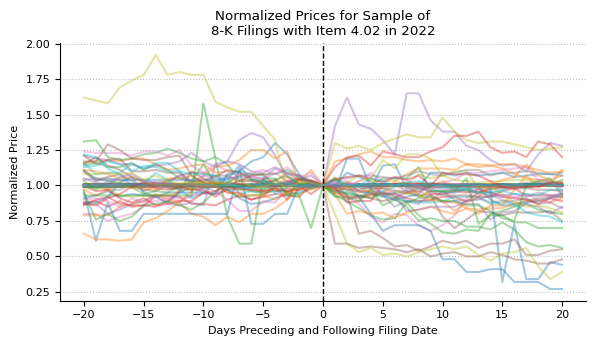

In [28]:
# Plot muli-line chart showing normalized prices for each filing
def plot_normalized_prices(df):
    fig, ax = plt.subplots(figsize=(6, 3.5))

    for i, row in df.iterrows():
        ticker = row["ticker"]
        filing_date = row["filedAt"]
        filing_date_str = filing_date.strftime("%Y-%m-%d")
        price_norm_columns = [col for col in row.index if "dNorm" in col]
        normalized_prices = row[price_norm_columns].dropna()
        x = range(-20, 21)
        y = normalized_prices.values
        if len(x) != len(y):
            continue
        ax.plot(
            x,
            normalized_prices.values,
            label=f"{ticker} - {filing_date_str}",
            alpha=0.4,
        )

    ax.set_title("Normalized Prices for Sample of\n8-K Filings with Item 4.02 in 2022")
    ax.set_xlabel("Days Preceding and Following Filing Date")
    ax.set_ylabel("Normalized Price")
    ax.axvline(0, color="black", linestyle="--", lw=1)
    plt.tight_layout()
    plt.show()


plot_normalized_prices(data_2022_w_prices)

In [29]:
import re

# Refine universe by filtering for specific dimensions, e.g. "restatementIsNecessary", "impactIsMaterial", etc.
# and calculate descriptive statistics of filtered sample
restatementIsNecessaryFilter = data_2022_w_prices["restatementIsNecessary"]

# Contains "revenue" or "loss" in reasonsForRestatement, identifiedIssue, or impactOfError
# regex_filter = re.compile(r"revenue|overstatement", re.IGNORECASE) # Works
regex_filter = re.compile(r"income|loss", re.IGNORECASE)

revenueRecognitionFilter = (
    data_2022_w_prices["reasonsForRestatement"].apply(
        lambda x: any(re.search(regex_filter, s) for s in x)
    )
    | data_2022_w_prices["identifiedIssue"].apply(
        lambda x: any(re.search(regex_filter, s) for s in x)
    )
    | data_2022_w_prices["impactOfError"].apply(
        lambda x: any(re.search(regex_filter, s) for s in x)
    )
)

filtered_sample = data_2022_w_prices[
    restatementIsNecessaryFilter & revenueRecognitionFilter
]

filtered_sample[price_return_columns].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
-20dReturn,15.0,-1.49,13.97,-23.91,-13.69,0.20,3.68,26.40
-10dReturn,16.0,2.15,10.18,-14.63,-2.36,0.02,5.31,28.72
-5dReturn,16.0,0.75,7.93,-7.82,-3.64,-0.36,1.15,24.41
-3dReturn,16.0,1.44,5.32,-10.04,-0.62,0.08,2.44,11.27
-1dReturn,16.0,-0.46,2.51,-3.41,-2.81,-0.12,0.10,6.52
1dReturn,16.0,-1.56,13.84,-40.51,-4.04,-0.24,0.00,30.42
3dReturn,16.0,-6.11,17.35,-44.03,-10.92,-7.54,0.11,28.50
5dReturn,16.0,-5.92,18.71,-44.12,-11.78,-2.94,0.10,30.05
10dReturn,16.0,-7.06,23.35,-48.28,-14.70,-6.52,0.19,47.67
20dReturn,16.0,-10.74,22.14,-51.63,-21.76,-6.06,0.36,26.57


- Comparing the median (50%) and mean of the E-20 to E+20 return, we find a succinct impact from the disclosure subset.
- The median 20-day return for the period preceding the disclosures is 0.2%, while the median 20-day return post-disclosure is -6.06%. 
- Mean -20 day return is -1.49%, while the mean +20 day return is -10.74%.
- The difference in median and mean returns suggests a negative impact of the disclosure subset on stock returns.

NOTE: In practice, you would use statistical tests to determine if the difference in returns is statistically significant, i.e. calculate t-statistics and p-values.

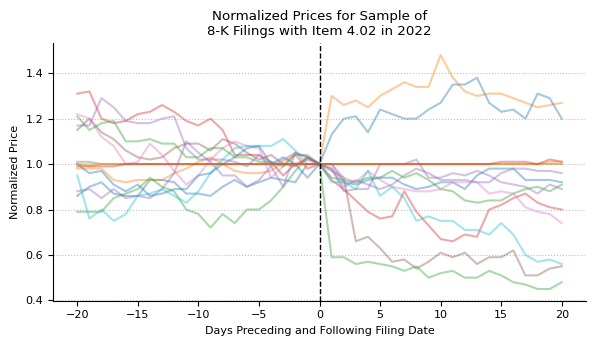

In [30]:
plot_normalized_prices(filtered_sample)

## Step 6: Enrich extracted data with fundamental data

Exercise: Load market cap, years since IPO, sector, industry, and other fundamental data for each CIK from WRDS, create subsets of the `structured_data_2022` dataframe by filtering on these fundamental data, and calculate X-day returns for each subset.

In [31]:
# Exercise: Load fundamental data for the companies from WRDS 
# and calculate X-day returns based on different filters,
# such as sector, industry, market cap, revenue, years since IPO, debt, etc